Investigate how having a lower lmax for the model than for the generated data
affects the results.

In [1]:
from pygdsm import GlobalSkyModel2016
import healpy as hp
import numpy as np
from scipy.special import eval_legendre
import matplotlib.pyplot as plt
import seaborn as sns

import src.beam_functions as BF
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.sky_models as SM
import src.map_making as MM

RS = SH.RealSphericalHarmonics()

3072 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


3072 561
Time taken to calculate:
G : 0.07386517524719238
Y : 8.106054067611694
B : 0.03783583641052246


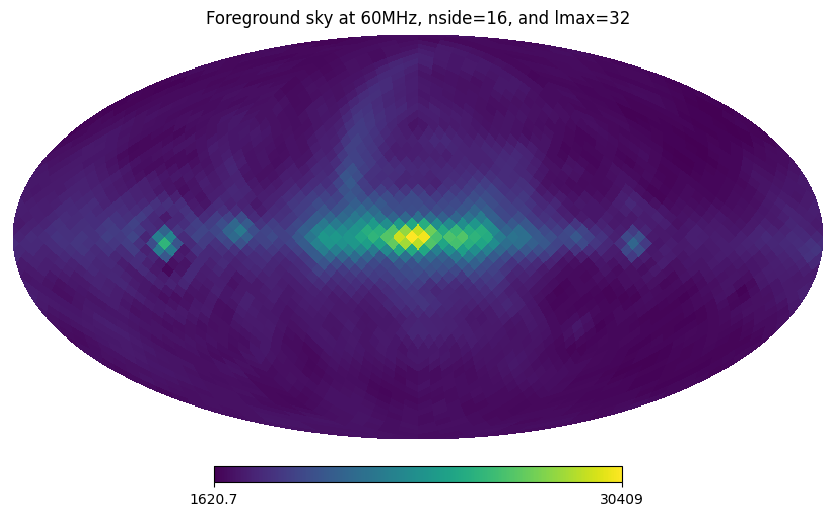

In [2]:
# Create a sky map of the foregrounds.
lmax = 32
nside = 16
npix = hp.nside2npix(nside)
ylm_mat = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmax)

fg_alm, fg_map = SM.foreground_gdsm_alm(nu=60, lmax=lmax, nside=nside, map=True)
hp.mollview(fg_map, title=f"Foreground sky at 60MHz, nside={nside}, and lmax={lmax}")

# Calculate total observation matrix.
tight_cosbeam = lambda theta: BF.beam_cos(theta, theta0=.8)
mat_A = FM.calc_observation_matrix_all_pix(
    nside=nside, 
    lmax=lmax, 
    Ntau=npix, 
    Nt=npix,
    beam_use=tight_cosbeam
)
# Generate data.
data = mat_A @ fg_alm
noisy_data, noise_cov = SM.add_noise(data, dnu=1, Ntau=npix, t_int=100)

3072 325
3072 325
Time taken to calculate:
G : 0.07361507415771484
Y : 4.624056816101074
B : 0.036759138107299805


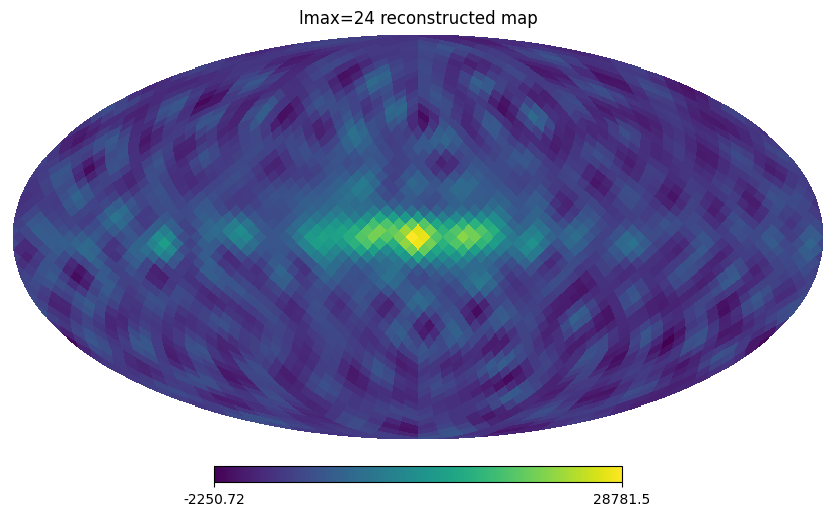

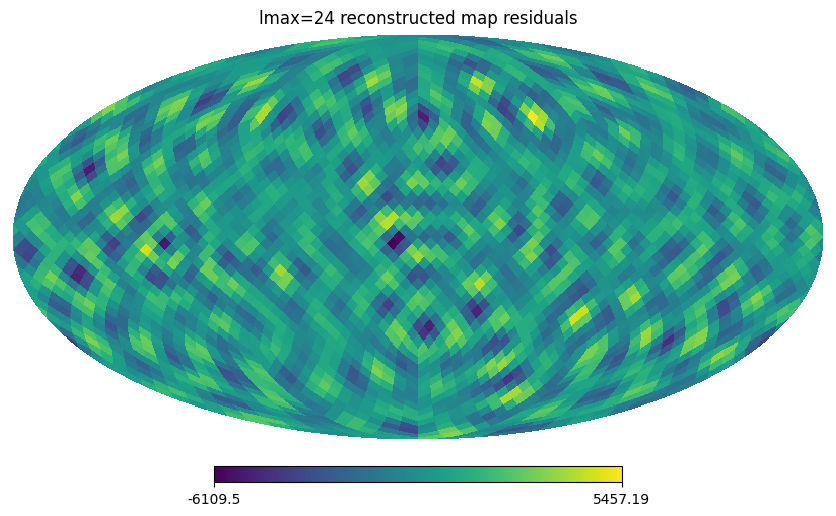

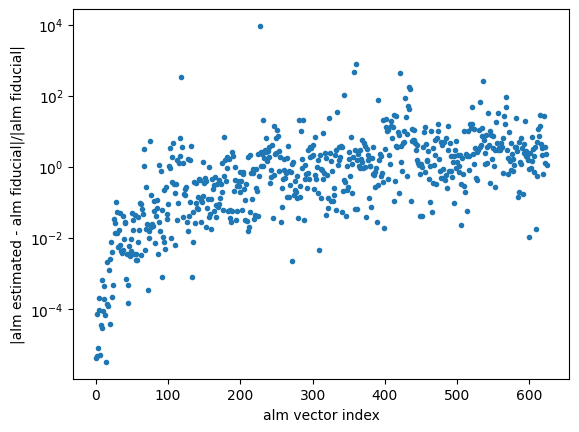

In [3]:
# Set up a fitting model with a different lmax.
lmax_mod = 24
ylm_mat_mod = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmax_mod)

mat_A_mod = FM.calc_observation_matrix_all_pix(
    nside=nside, 
    lmax=lmax_mod, 
    Ntau=npix, 
    Nt=npix,
    beam_use=tight_cosbeam
)

# Invert to make map.
mat_W, model_covar = MM.calc_ml_estimator_matrix(
    mat_A=mat_A_mod, 
    mat_N=noise_cov, 
    cov=True
)
model_estimate = mat_W @ noisy_data

# Plot
hp.mollview(ylm_mat_mod@model_estimate, title=f"lmax={lmax_mod} reconstructed map")
plt.show()

hp.mollview(ylm_mat_mod@model_estimate - ylm_mat@fg_alm, title=f"lmax={lmax_mod} reconstructed map residuals")
plt.show()

no_modes = np.min((len(model_estimate), len(fg_alm)))
plt.semilogy(range(no_modes), abs(model_estimate[:no_modes] - fg_alm[:no_modes])/abs(fg_alm[:no_modes]), '.')
plt.xlabel("alm vector index")
plt.ylabel("|alm estimated - alm fiducial|/|alm fiducial|")
plt.show()

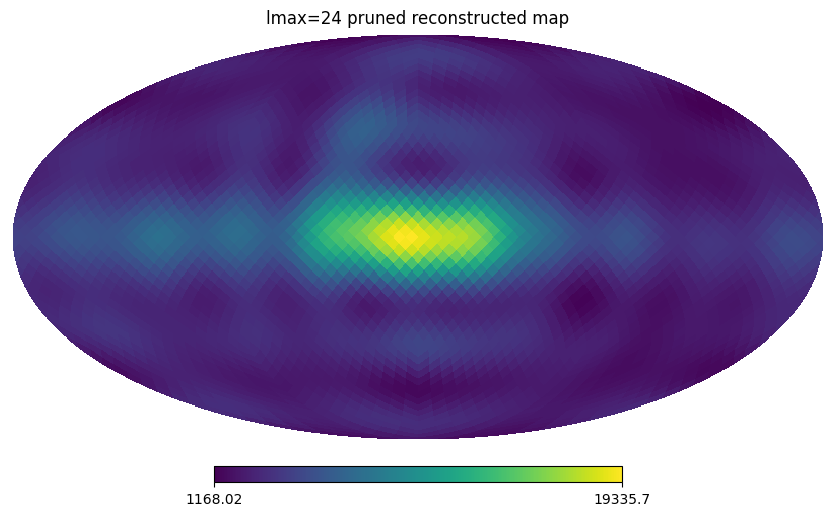

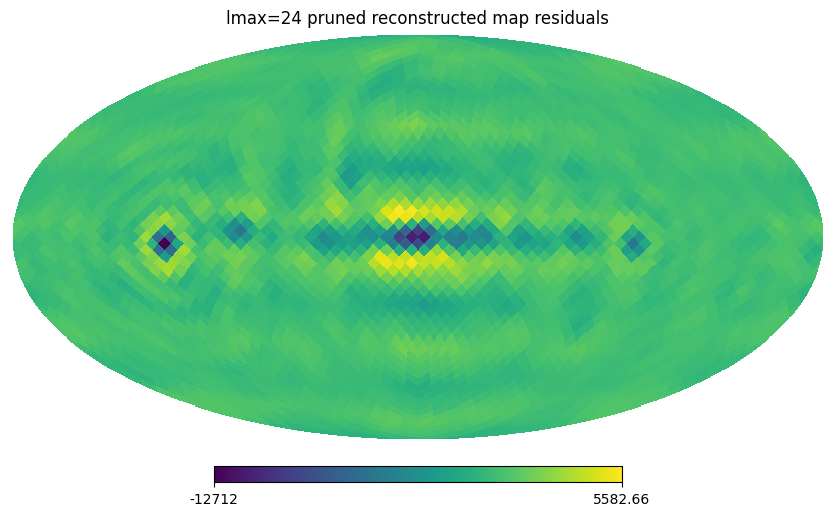

In [4]:
# See what cutting off higher order modes does for the reconstruction.
cutoff_index = 125
model_estimate_pruned = np.array(model_estimate)
model_estimate_pruned[cutoff_index:] = np.zeros(len(model_estimate_pruned[cutoff_index:]))

hp.mollview(ylm_mat_mod@model_estimate_pruned, title=f"lmax={lmax_mod} pruned reconstructed map")
plt.show()

hp.mollview(ylm_mat_mod@model_estimate_pruned - ylm_mat@fg_alm, title=f"lmax={lmax_mod} pruned reconstructed map residuals")
plt.show()

Simply cutting things off doesn't improve stuff.

## Foreground power spectrum

Assume isotropy for the unmodelled modes. This means that we pretend they are
drawn from a gaussian distribution given by the variance and mean of each set of
m modes for a given l mode. 

We modify the noise covariance matrix with an extra matrix to include this.

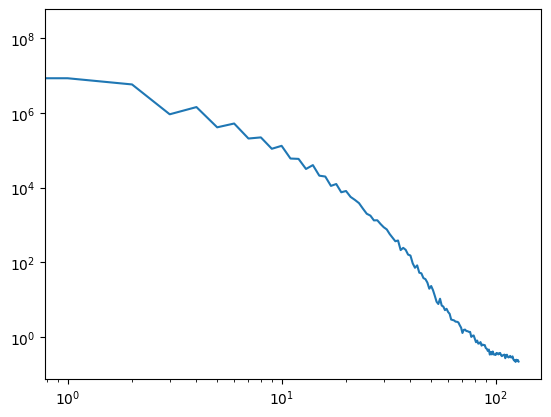

In [5]:
fg_full_map = GlobalSkyModel2016(resolution='low').generate(60)
fg_cl = hp.sphtfunc.anafast(fg_full_map, lmax=64*2)
plt.loglog(fg_cl)

In [6]:
def calc_basic_unmodelled_mode_matrix(lmod, lmax, nside, foreground_power_spec, beam_mat):
    """
    Calculate the unmodelled mode matrix for the trivial observation strategy and
    no binning of timeseries data.
    """
    npix = hp.nside2npix(nside)
    vectors = hp.pix2vec(nside, ipix=list(range(npix)))
    vectors = np.array(vectors).T
    vector_difference = np.einsum("pi,qi->pq", vectors, vectors)

    val = np.sum([((2*l+1)/(4*np.pi)) * eval_legendre(l, vector_difference) * foreground_power_spec[l] * beam_mat[l,l]**2 for l in range(lmod+1, lmax)], axis=0)
    return val


In [7]:
beam_mat = BF.calc_beam_matrix(nside=nside, lmax=lmax_mod, beam_use=tight_cosbeam)
mat_S = calc_basic_unmodelled_mode_matrix(lmod=lmax_mod, lmax=lmax, foreground_power_spec=fg_cl, nside=nside, beam_mat=beam_mat)

In [8]:
# Set up a fitting model with a different lmax.
ylm_mat_mod = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmax_mod)

mat_A_mod = FM.calc_observation_matrix_all_pix(
    nside=nside, 
    lmax=lmax_mod, 
    Ntau=npix, 
    Nt=npix,
    beam_use=tight_cosbeam
)

# Invert to make map.
mat_W, model_covar = MM.calc_ml_estimator_matrix(
    mat_A=mat_A_mod, 
    mat_N=noise_cov + mat_S, 
    cov=True
)
model_estimate_new = mat_W @ noisy_data


3072 325
3072 325
Time taken to calculate:
G : 0.02964496612548828
Y : 4.874307155609131
B : 0.03658580780029297


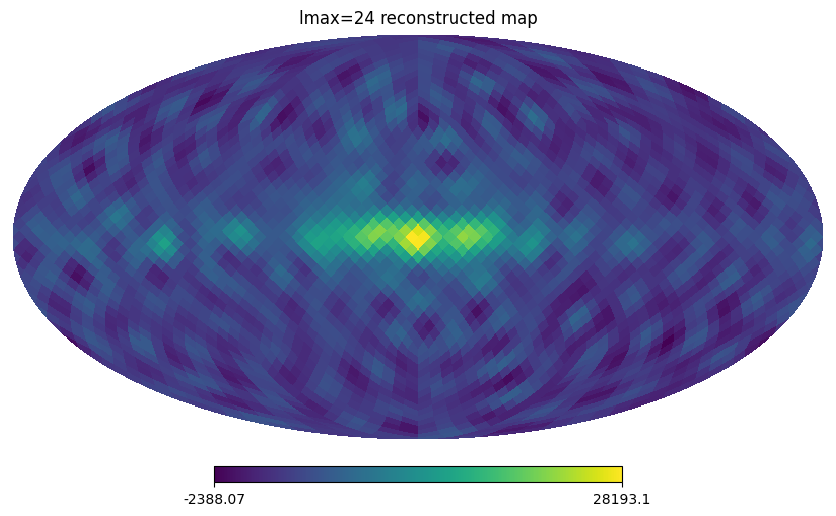

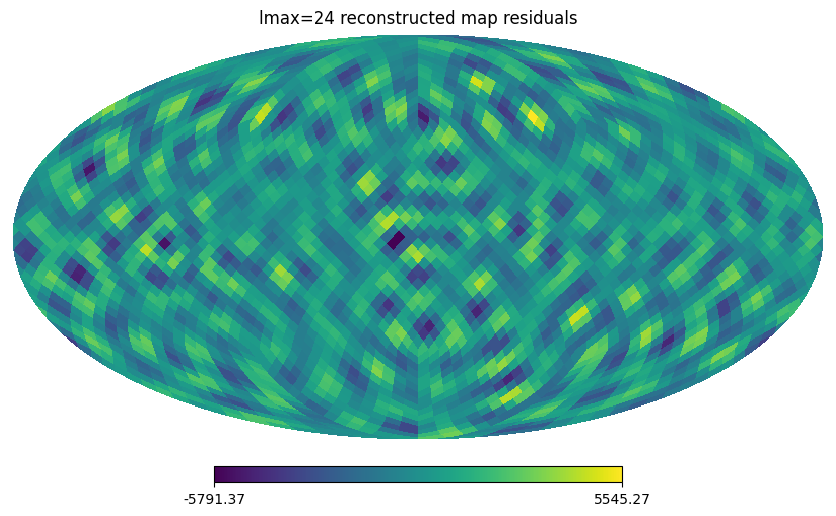

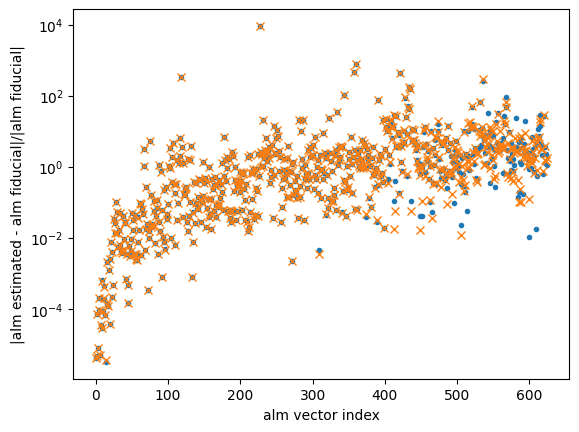

In [9]:

# Plot
hp.mollview(ylm_mat_mod@model_estimate_new, title=f"lmax={lmax_mod} reconstructed map")
plt.show()

hp.mollview(ylm_mat_mod@model_estimate_new - ylm_mat@fg_alm, title=f"lmax={lmax_mod} reconstructed map residuals")
plt.show()

no_modes = np.min((len(model_estimate), len(fg_alm)))
plt.semilogy(range(no_modes), abs(model_estimate[:no_modes] - fg_alm[:no_modes])/abs(fg_alm[:no_modes]), '.')
plt.semilogy(range(no_modes), abs(model_estimate_new[:no_modes] - fg_alm[:no_modes])/abs(fg_alm[:no_modes]), 'x')
plt.xlabel("alm vector index")
plt.ylabel("|alm estimated - alm fiducial|/|alm fiducial|")
plt.show()

## Check this using a gaussian random field.
Use the foreground power spectrum to generate a Gaussian random field up to lmax

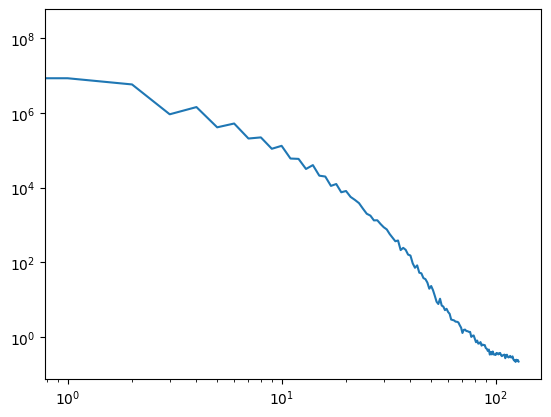

In [10]:
fg_full_map = GlobalSkyModel2016(resolution='low').generate(60)
fg_cl = hp.sphtfunc.anafast(fg_full_map, lmax=64*2)
plt.loglog(fg_cl)

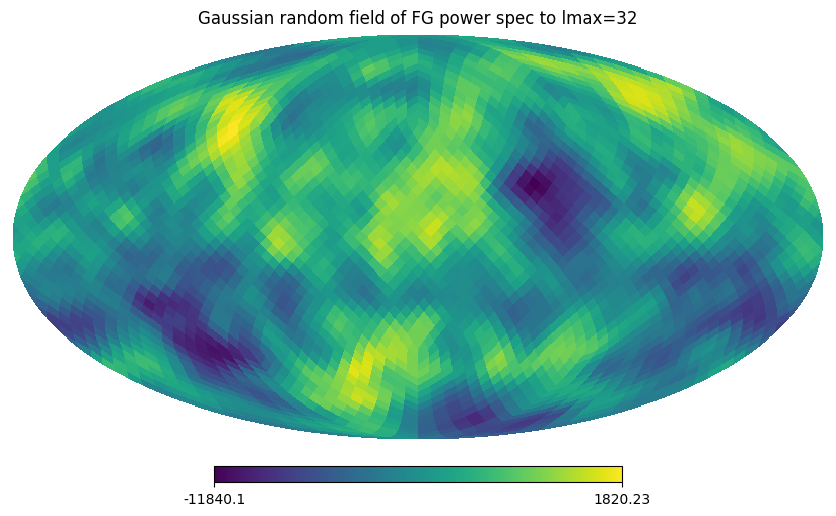

In [11]:
np.random.seed(123)
fg_gauss_map = hp.synfast(fg_cl, lmax=lmax, nside=nside)
hp.mollview(fg_gauss_map, title=f"Gaussian random field of FG power spec to lmax={lmax}")

In [12]:
# Observe (forward-model) the Gaussian field.
fg_alm_gauss = hp.sphtfunc.map2alm(fg_gauss_map, lmax=lmax)
fg_alm_gauss = RS.complex2RealALM(fg_alm_gauss)

data = mat_A @ fg_alm_gauss
noisy_data_gauss, noise_cov_gauss = SM.add_noise(data, dnu=1, Ntau=npix, t_int=100)

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


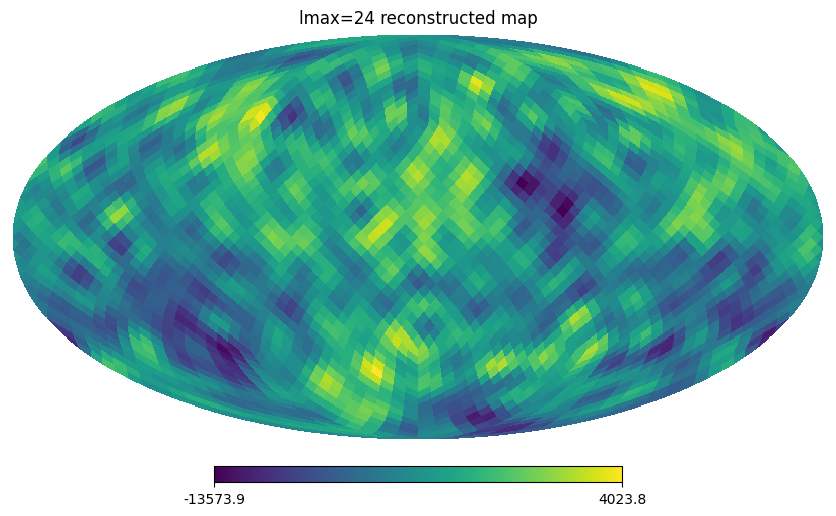

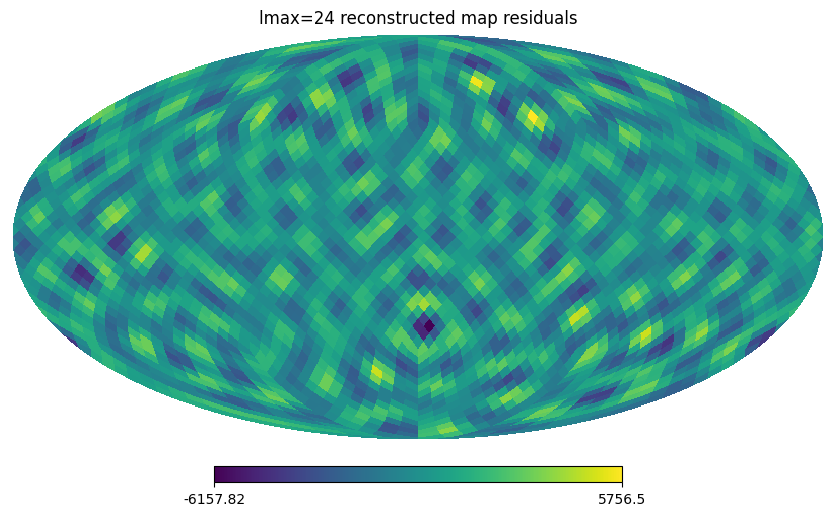

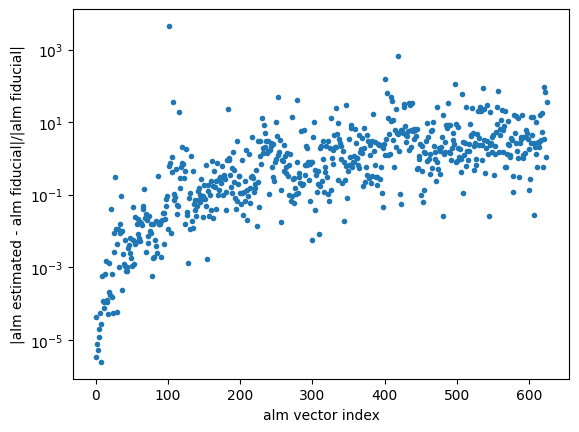

In [17]:
# Invert fitting model to make the map with the gaussian noise.
mat_W, model_covar = MM.calc_ml_estimator_matrix(
    mat_A=mat_A_mod, 
    mat_N=noise_cov_gauss, 
    cov=True
)
model_estimate = mat_W @ noisy_data_gauss

# Plot
hp.mollview(ylm_mat_mod@model_estimate, title=f"lmax={lmax_mod} reconstructed map")
plt.show()

hp.mollview(ylm_mat_mod@model_estimate - ylm_mat@fg_alm_gauss, title=f"lmax={lmax_mod} reconstructed map residuals")
plt.show()

no_modes = np.min((len(model_estimate), len(fg_alm_gauss)))
plt.semilogy(range(no_modes), abs(model_estimate[:no_modes] - fg_alm_gauss[:no_modes])/abs(fg_alm_gauss[:no_modes]), '.')
plt.xlabel("alm vector index")
plt.ylabel("|alm estimated - alm fiducial|/|alm fiducial|")
plt.show()

In [69]:
def mean_std_l(a):
    """
    Takes a real alm vector a, and calculates the mean and standard dev of each
    l component it contains. Returns the tuple: (mean_array, std_array)
    """
    # Test input.
    lmax = RS.get_lmax(len(a))
    means = [a[0]**2]
    stds  = [0]
    for l in range(1, int(lmax)+1):
        alms = np.array(a[RS.get_idx(l=l,m=-l) : RS.get_idx(l=l,m=+l)+1])
        means.append(np.mean(alms**2))
        stds.append(np.std(alms**2))

    return np.array(means), np.array(stds)
        

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


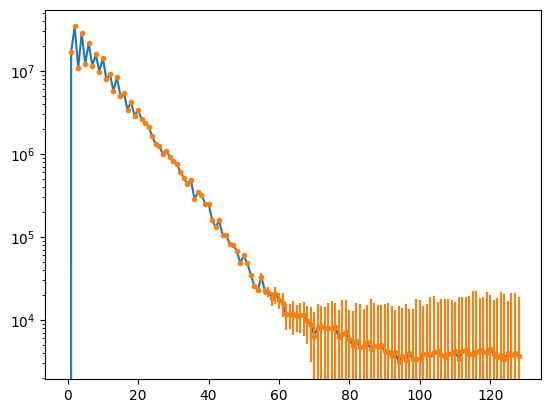

In [74]:
fg_alm_all = hp.sphtfunc.map2alm(fg_full_map, lmax=128)
fg_alm_all_r = RS.complex2RealALM(fg_alm_all)
fg_alm_means, fg_alm_stds = mean_std_l(fg_alm_all_r)
yerr = np.sqrt((fg_alm_stds/(fg_alm_means*np.log(10)))**2)

norm = np.array([l*(l+1) for l in range(len(fg_alm_means))])
plt.semilogy(norm*fg_cl)
plt.errorbar(list(range(len(fg_alm_means))), norm*fg_alm_means, yerr=norm*yerr, fmt='.')
plt.show()
#plt.ylim(-.1e8,0.5e8)

## Foreground phase rotation

This reconstruction seems significantly worse than the previous one. A possible 
reason is that the unmodelled modes are not isotropic and gaussian. To visualise 
whether they are, rotate the phases of the alm in the default foregrounds and
see how much they change.

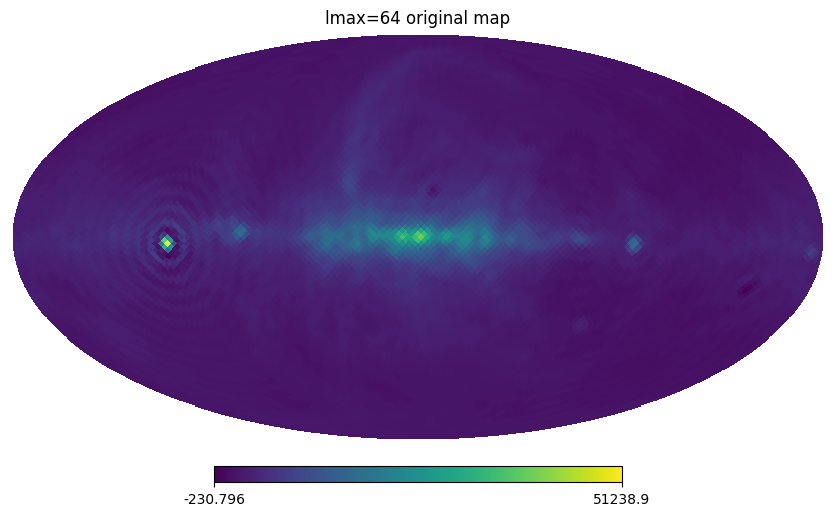

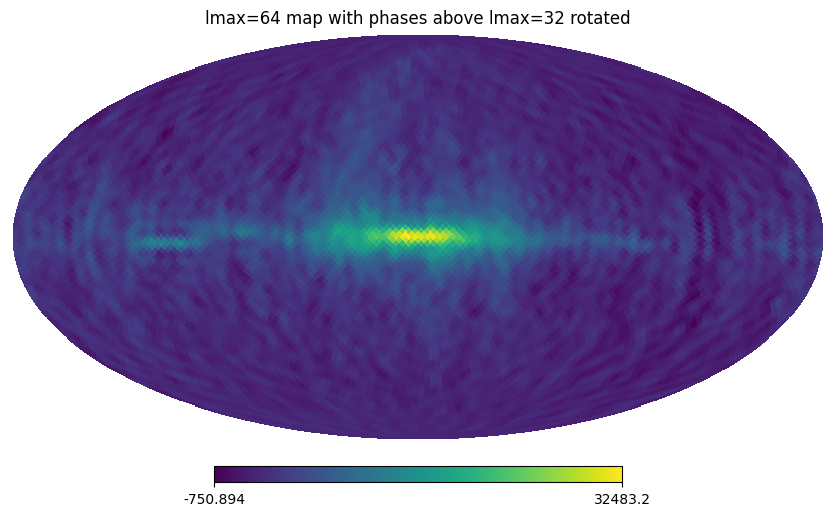

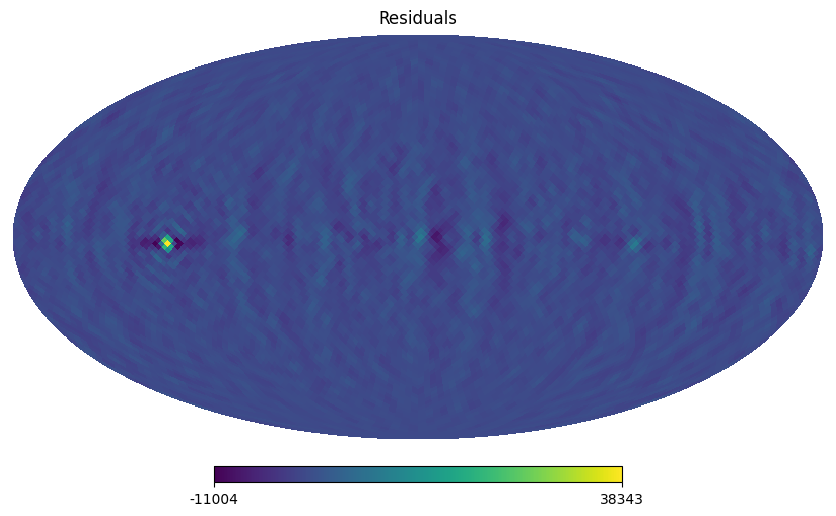

In [9]:
nside_big = 32
lmax_big  = 64
ylm_mat_big = np.load("saves/ylm_mat_nside32_lmax64.npy")

fg_alm = SM.foreground_gdsm_alm(nu=60, lmax=lmax_big, nside=nside_big)
fg_alm_complex = SH.RealSphericalHarmonics().real2ComplexALM(fg_alm)

# Rotate the phases of the complex alm from l=32 to l=64.
l32_size = int(0.5*(32+1)*(32+2))
l64_size = int(0.5*(64+1)*(64+2))
random_phases = np.random.uniform(0, 2*np.pi, size=(l64_size-l32_size))
rotated_alm_complex = np.array(fg_alm_complex)
rotated_alm_complex[l32_size:] = fg_alm_complex[l32_size:] * np.exp(1j * random_phases)

# Convert back to real spherical harmonics
rotated_alm = SH.RealSphericalHarmonics().complex2RealALM(rotated_alm_complex)

hp.mollview(ylm_mat_big@fg_alm, title=f"lmax=64 original map")
plt.show()
hp.mollview(ylm_mat_big@rotated_alm, title=f"lmax=64 map with phases above lmax=32 rotated")
plt.show()
hp.mollview(ylm_mat_big@(fg_alm-rotated_alm), title=f"Residuals")
plt.show()



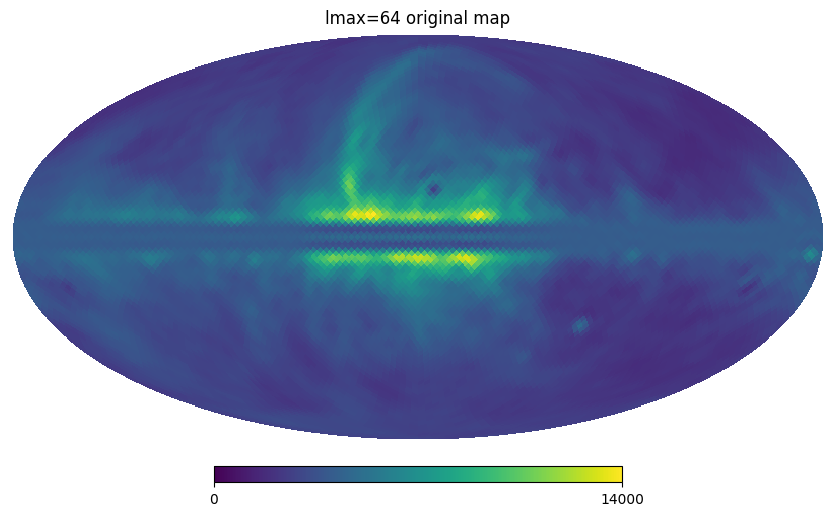

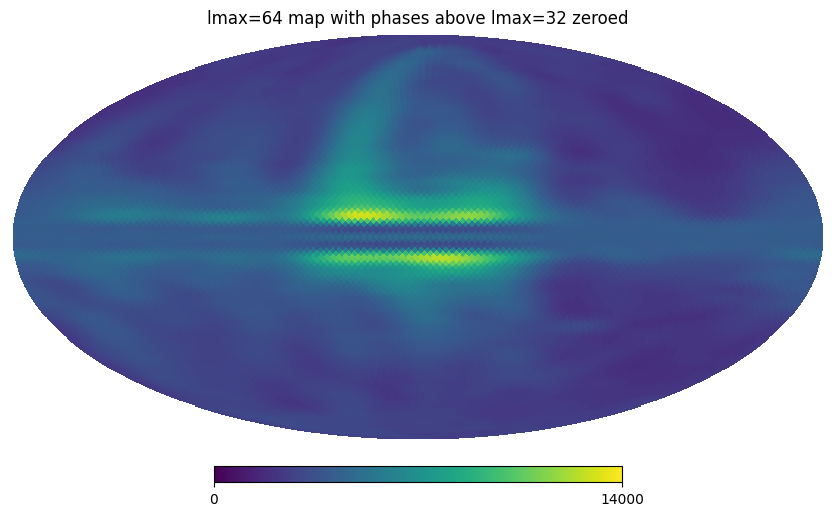

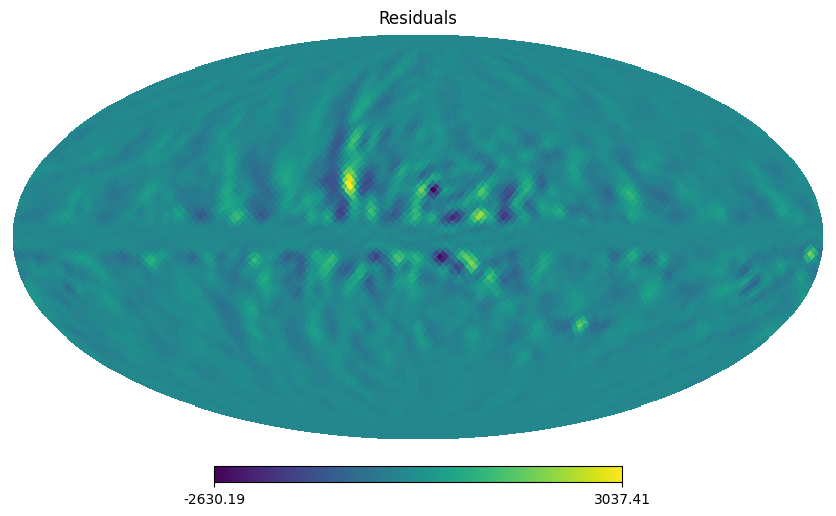

In [5]:
nside_big = 32
lmax_big  = 64
ylm_mat_big = np.load("saves/ylm_mat_nside32_lmax64.npy")

fg_alm = SM.foreground_gdsm_galcut_alm(nu=60, lmax=lmax_big, nside=nside_big)
fg_alm_complex = SH.RealSphericalHarmonics().real2ComplexALM(fg_alm)

# Rotate the phases of the complex alm from l=32 to l=64.
l32_size = int(0.5*(32+1)*(32+2))
l64_size = int(0.5*(64+1)*(64+2))
random_phases = np.random.uniform(0, 2*np.pi, size=(l64_size-l32_size))
rotated_alm_complex = np.array(fg_alm_complex)
rotated_alm_complex[l32_size:] = 0#fg_alm_complex[l32_size:] * np.exp(1j * random_phases)

# Convert back to real spherical harmonics
rotated_alm = SH.RealSphericalHarmonics().complex2RealALM(rotated_alm_complex)

hp.mollview(ylm_mat_big@fg_alm, title=f"lmax=64 original map", min=0, max=14000)
plt.show()
hp.mollview(ylm_mat_big@rotated_alm, title=f"lmax=64 map with phases above lmax=32 zeroed", min=0, max=14000)
plt.show()
hp.mollview(ylm_mat_big@(fg_alm-rotated_alm), title=f"Residuals")
plt.show()